# Update Algorithm Simualtions

These simulations are part of the project efforts of critical reviewing the paper [1].

## Background

In this paper the authors proposed a mathematical model for the flow control problem. The cost function of the model consists of two components:

- Pricing function, defined as
  $P_i(x_i, x_{-i}) = \frac{k_i}{m - (x_i + x_{-i})^+} x_i^2$
- Linear utility function, defined as
  $\tilde{U}_i(x_i) = a_ix_i + \tilde{d}_i, \; x_i \geq 0 \, \forall i.$

The cost function is simply $\tilde{J}_i = P_i - \tilde{U}_i.$ The paper also proposed a non-linear utility function which is defined as $U_i(x_i) = \ln(1+x_i)+d_i, \; x_i \geq 0 \, \forall i$, however we will focus on linear cost function only in this project.

The paper also claimed three different update algorithms:

- PUA, parallel update algorithm, where $x_i^{(n+1)} = mq_i - q_i x_{-i}^{(n)} \; \forall i, n$,
- RUA, random update algorithm, where $x_i^{(n+1)} = \begin{cases}mq_i - q_i x_{-i}^{(n)}, & \text{with probability } p_i,\\ x_i^{(n)}, & \text{with probability }1 - p_i \end{cases}$,
- GUA, gradient upate algorithm, where $x_i^{(n+1)} = x_i^{(n)} + s_i \cdot [(mq_i - x_{-i}^{(n)}q_i) - x_i^{(n)}]\; \forall i, n$,

where $q_i = 1 - \left(\frac{k_i}{k_i + a_i}\right)^\frac{1}{2}$.

The paper also claimed that to ensure stability, $k_i \geq \frac{(M-1)^2}{2M-1} a_i$.


To simplify the simulation, we assume symmetric users, thus the parameters in the model such as $k, a, q, p, s$ are constant across all users.

# Model Definition

This simulation is done with Python. First, we need to import the necessary libraries.

In [0]:
import random
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

Next, we define a class `Simulation` to represent the model and update algorithms defined above. Starting condition is the origin, i.e. `self.xs` is zero vector. The `threshold` defines the stopping criterion by $\sum_{i=1}^M |x_i^{(n+1)} - x_i^{(n)}| \leq M \cdot \epsilon$, where $\epsilon$ is given when running the simulation, usually $\epsilon = 10^{-5}$.

In [0]:
class Simulation:

    def __init__(self, M,  k, a, m=100, d=1, init=None, delay=None):
        """
        :param M: number of users
        :param k: price parameter
        :param delay: A function used to decide the delay factor. The function will be called with the following signature:
                        `delay(M, i)`
                      where M is the number of users and i is the user currently dealing with.
                      Return the delay corresponding to the i-th user.

                      For example, the 4-group
            
        """
        self.M = M
        self.m = m
        self.k = k
        self.a = a
        self.d = d
        self.q = 1 - np.sqrt(self.k / (self.k + a))

        self.history = []
        self.delay = delay

        self.init = init
        self.reset()

    def price(self, i):
        """Compute the price of x_i given xs.
        This function will compute P_i(x_i, x_{-i}).
        :param xs: float[M], the excess bandwidth taken by each user
        :param i: The user we are interested in
        """
        return self.k / (m - sum(self.xs)) * self.xs[i] * self.xs[i]

    def reset(self):
        if self.init is None:
            self.xs = np.zeros(self.M)
        else:
            self.xs = copy.deepcopy(self.init)
        
        self.history = []

    def log_utility(self, i):
        return np.log(1 + self.xs[i]) + self.d

    def linear_utility(self, i):
        return self.a * self.xs[i] + self.d

    def log_cost(self, i):
        return self.price(i) - self.log_utility(i)

    def xs_next(self):
        """Compute the next step for each player.
        """
        # No delay, just compute from the last xs
        if self.delay is None:
            return self.q * (self.m - (np.sum(self.xs) - self.xs))
        else:
            # compute each x_i based on the delay
            # note the `self.history` array is arranged by time
            # Assume current time = t, and we want to calculate x(t)
            # then, self.xs stores x(t-1)
            # self.history[-1] stores x(t-2)
            # self.history[-2] stores x(t-3)
            # ...
            new_xs = []
            for i in range(len(self.xs)):
                delay = self.delay(self.M, i)
                if delay == 0:
                    # delay is 0, just use x(t-1) i.e. self.xs
                    # but instead of using np array operation, we have to calculate for every x
                    x = self.q * (self.m - (np.sum(self.xs) - self.xs[i]))
                else:
                    # if history is shorter than delay, it means that current agent should not response yet
                    # simply return current xs value
                    if len(self.history) < delay:
                        x = self.xs[i]
                    else:
                        # otherwise, calculate using history
                        x = self.q * (self.m - (np.sum(self.history[-delay]) - self.history[-delay][i]))
                new_xs.append(x)

            return np.array(new_xs)

            self.history.append(self.xs)
            self.xs = new_xs

    def pua(self):
        """Parallel update algorithm.
        """
        # Only if we have a delay function we save the history
        if self.delay is not None:
            self.history.append(self.xs)

        new_xs = self.xs_next()
        diff = new_xs - self.xs

        self.xs = new_xs
        return diff

    def rua(self, p):
        """Random update algorithm.
        `p` is the updating probability.
        """
        # Only if we have a delay function we save the history
        if self.delay is not None:
            self.history.append(self.xs)

        new_xs = self.xs_next()
        for i in range(self.M):
            if random.random() > p:
                new_xs[i] = self.xs[i]

        diff = new_xs - self.xs

        self.xs = new_xs
        return diff

    def gua(self, s):
        """Gradient update algorithm.
        `s` is the relaxization parameter.
        """
        # Only if we have a delay function we save the history
        if self.delay is not None:
            self.history.append(self.xs)

        new_xs = self.xs * (1-s) + self.xs_next() * s
        diff = new_xs - self.xs

        self.xs = new_xs
        return diff

    def threshold(self, diff, epsilon):
        """Test if current strategies reach the threshold, given by `epsilon`.
        """
        return np.sum(np.abs(diff)) <= self.M * epsilon

    def run(self, epsilon, algorithm, *args, **kwargs):
        """Run the simulation.
        """
        result = []
        result.append(self.xs)
        n_iter = 0

        while True:
            n_iter += 1

            # fail safe
            if n_iter > 100:
                break

            diff = algorithm(*args, **kwargs)
            result.append(self.xs)

            if self.threshold(diff, epsilon):
                break
        
        return np.array(result), n_iter



## 5.1 Simulation for Delay-free Case

First we study the convergence of PUA, RUA and GUA under the condition $M=20, a=1, k=10$. We can compute that to ensure the stability, we must have $k \geq \frac{(20 - 1)^2}{2 \times 20 - 1} \times 1 = 9.2546$, thus $k=10$ will make the NE solution stable.

In [0]:
sim = Simulation(M=20, k=10, a=1)
pua_result, pua_n_iter = sim.run(10e-5, sim.pua)
pua_rates = np.sum(pua_result, axis=1)

sim.reset()
rua_result, rua_n_iter = sim.run(10e-5, sim.rua, p=0.66667)
rua_rates = np.sum(rua_result, axis=1)

sim.reset()
gua_result, gua_n_iter = sim.run(10e-5, sim.gua, s=0.5)
gua_rates = np.sum(gua_result, axis=1)

print('# Iterations before convergence: PUA = %s, RUA = %s, GUA = %s' % (pua_n_iter, rua_n_iter, gua_n_iter))



# Iterations before convergence: PUA = 89, RUA = 13, GUA = 5


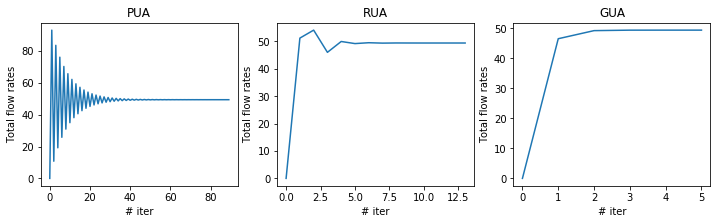

In [0]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.plot(pua_rates)
plt.xlabel('# iter')
plt.ylabel('Total flow rates')
plt.title('PUA')

plt.subplot(1, 3, 2)
plt.plot(rua_rates)
plt.xlabel('# iter')
plt.ylabel('Total flow rates')
plt.title('RUA')

plt.subplot(1, 3, 3)
plt.plot(gua_rates)
plt.xlabel('# iter')
plt.ylabel('Total flow rates')
plt.title('GUA')

plt.show()


we can see that undesirable, wide oscillations in flow rates can be observed in PUA, while GUA can achieve a smooth convergence. Also, RUA and GUA converges much faster than PUA.

Next we study the convergence for the PUA with different $k$. We will run simlations for the same $M=20$, but with $k = 10, \cdots, 50$.


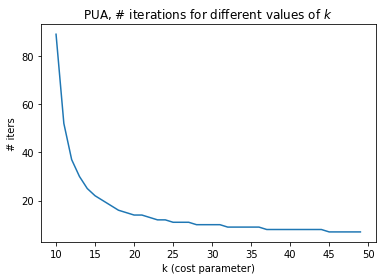

In [0]:
result2 = []
for k in range(10, 50):
    sim = Simulation(M=20, k=k, a=1)
    result, n_iter = sim.run(10e-5, sim.pua)
    result2.append([k, n_iter])

result2 = np.array(result2).T
plt.plot(result2[0], result2[1])
plt.xlabel('k (cost parameter)')
plt.ylabel('# iters')
plt.title('PUA, # iterations for different values of $k$')
plt.show()
    

Now we study the convergence of RUA. We investigate the two parameters of RUA $M$, number of users and $p$, the update probability. Since we use $M \in [1, 100]$, the corresponding $k \geq (100-1)^2 / (2 \times 100 - 1) = 49.25$ to ensure the convergence. So in the next simulation we take $k = 60$. (using $k = 50$ could ensure convergence too, howver the # of iterations when $M = 100$ may go beyond our iteration cap 100. For safety we choose $k = 60$.)


In [0]:
results = []
Ms = np.linspace(1, 100, 20)
ps = np.linspace(0.1, 0.99, 20)
Ms, ps = np.meshgrid(Ms, ps)
iters = np.zeros(shape=Ms.shape)

for i in range(len(Ms)):
    for j in range(len(ps)):
        sim = Simulation(M=int(Ms[i, j]), k=60, a=1)
        result, n_iter = sim.run(10e-5, sim.rua, ps[i, j])
        iters[i, j] = n_iter
        

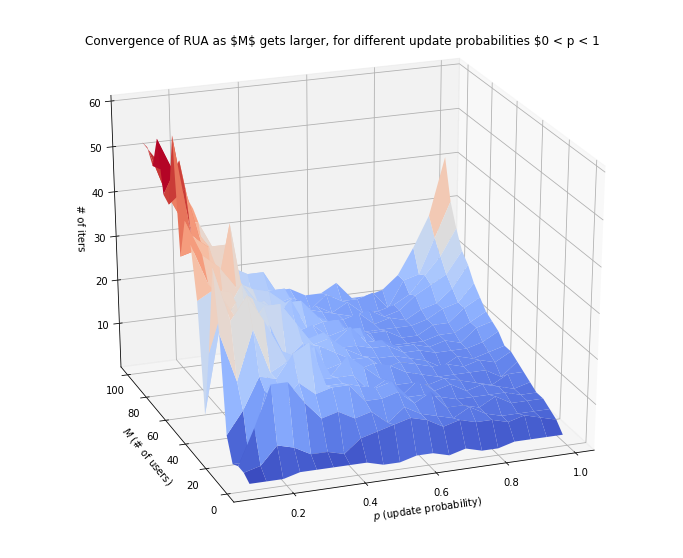

In [0]:
# plot the change of # iters with M and p
fig = plt.figure(figsize=(12, 10))
ax = fig.gca(projection='3d')
ax.plot_surface(X=ps, Y=Ms, Z=iters, cmap=cm.coolwarm, linewidth=1)
ax.view_init(25, 250)
ax.set_xlabel('$p$ (update probability)')
ax.set_ylabel('$M$ (# of users)')
ax.set_zlabel('# of iters')
ax.set_title('Convergence of RUA as $M$ gets larger, for different update probabilities $0 < p < 1')
plt.show()

It is observed that with the increasing number of users, the optimal update probability gets closer to the value $3/3$.

We can also observe that as $p \to 1$, the number of iterations increases dramastically. An interpretation is that as $p \to 1$, RUA gets more similar to PUA, thus taking more iterations to converge.

Similar to RUA, we did the simulation for GUA algorithm with $M \in [1, 100], k = 50, s \in (0, 1)$.

In [0]:
results = []
Ms = np.linspace(1, 100, 20)
ss = np.linspace(0.1, 0.99, 20)
Ms, ss = np.meshgrid(Ms, ss)
iters = np.zeros(shape=Ms.shape)

for i in range(len(Ms)):
    for j in range(len(ss)):
        sim = Simulation(M=int(Ms[i, j]), k=60, a=1)
        result, n_iter = sim.run(10e-5, sim.gua, ss[i, j])
        iters[i, j] = n_iter
        

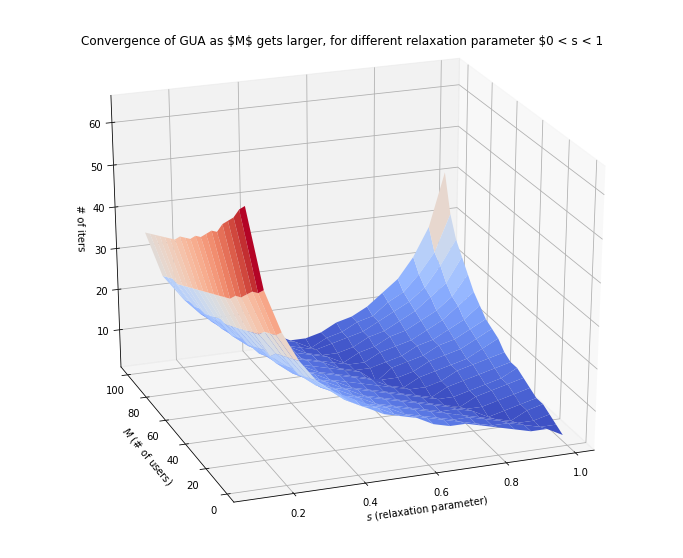

In [0]:
# plot the change of # iters with M and s
fig = plt.figure(figsize=(12, 10))
ax = fig.gca(projection='3d')
ax.plot_surface(X=ps, Y=Ms, Z=iters, cmap=cm.coolwarm, linewidth=1)
ax.view_init(25, 250)
ax.set_xlabel('$s$ (relaxation parameter)')
ax.set_ylabel('$M$ (# of users)')
ax.set_zlabel('# of iters')
ax.set_title('Convergence of GUA as $M$ gets larger, for different relaxation parameter $0 < s < 1')
plt.show()

It can be observed that as the number of users increases, the optimal $s$ approaches 0.5, which confirms the theoretical result (38) in the original paper. The paper also mentioned that for other initial conditiona may lead to different optimal values for $s$. This is confirmed with the following simulation.


In [0]:
results = []
Ms = np.linspace(1, 100, 20)
ss = np.linspace(0.1, 0.99, 20)
Ms, ss = np.meshgrid(Ms, ss)
iters = np.zeros(shape=Ms.shape)

for i in range(len(Ms)):

    for j in range(len(ss)):

        M = int(Ms[i, j])
        # Randomize initial condition
        dist = np.random.randn(M)
        total = np.sum(dist)

        # M users randomly acquire 50 bandwidth in total (as we used m=100 by default)
        init = dist / total * 50

        sim = Simulation(M=M, k=60, a=1, init=init)
        result, n_iter = sim.run(10e-5, sim.gua, ss[i, j])
        iters[i, j] = n_iter
        

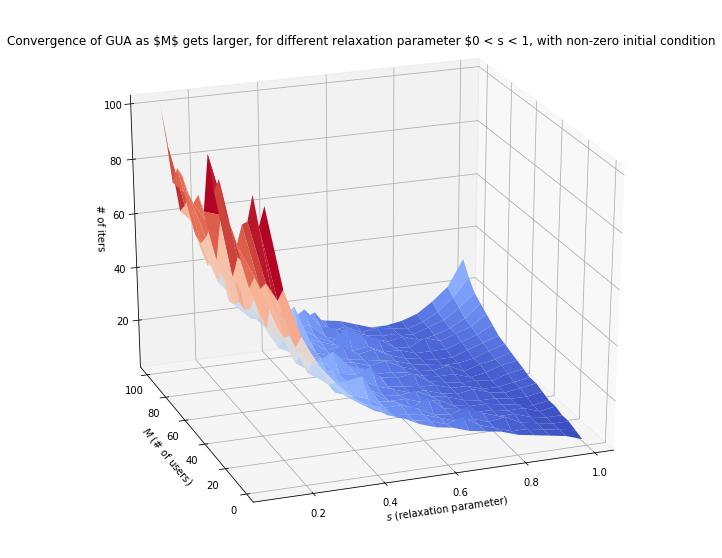

In [0]:
# plot the change of # iters with M and s
fig = plt.figure(figsize=(12, 10))
ax = fig.gca(projection='3d')
ax.plot_surface(X=ps, Y=Ms, Z=iters, cmap=cm.coolwarm, linewidth=1)
ax.view_init(25, 250)
ax.set_xlabel('$s$ (relaxation parameter)')
ax.set_ylabel('$M$ (# of users)')
ax.set_zlabel('# of iters')
ax.set_title('Convergence of GUA as $M$ gets larger, for different relaxation parameter $0 < s < 1, with non-zero initial condition')
plt.show()

It is observed that the optimal $s$ ranges between 0.6 and 0.8.

Finally we will compare the convergence rate of all three algorithms for different number of users. We will use $M \in [1, 100], k = 60, p = 2/3, s = 0.5$.


In [0]:
df = pd.DataFrame(columns=['M', 'pua', 'rua', 'gua'])

for M in range(10, 100, 10):
    sim = Simulation(M=M, k=60, a=1)
    result, pua_iter = sim.run(10e-5, sim.pua)
    sim.reset()
    result, rua_iter = sim.run(10e-5, sim.rua, p = 2/3)
    sim.reset()
    result, gua_iter = sim.run(10e-5, sim.gua, s = 0.5)

    df = df.append({'M': M, 'pua': pua_iter, 'rua': rua_iter, 'gua': gua_iter}, ignore_index=True)

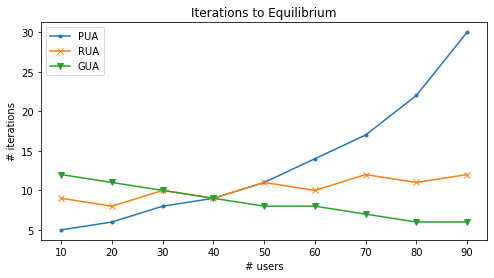

In [0]:
plt.figure(figsize=(8, 4))
plt.plot(df.M, df.pua, marker='.', label='PUA')
plt.plot(df.M, df.rua, marker='x', label='RUA')
plt.plot(df.M, df.gua, marker='v', label='GUA')
plt.xlabel('# users')
plt.ylabel('# iterations')
plt.legend()
plt.title('Iterations to Equilibrium')
plt.show()

We can observe clearly that GUA and RUA are superior to PUA, as the original paper claimed. Also it can be observed that the convergence of RUA and GUA are almost independent of the number of users.

## Simations with Delay

Here we use the same settings as in the original paper, i.e. four-group system, the first group has no delay, the second one has one unit delay, the third group has two unit delay, and so on. Thus the delay function used here is simply `floor(4 * i / M)`.

First, we do the same simulation on all three algorithms to get an intuitive understanding of the convergence. Here we use $M = 20, k = 10, a = 1$, and the four-group system delay setup.

In [0]:
sim = Simulation(M=20, k=10, a=1, delay=lambda MM, ii: int(4 * ii / MM))
pua_result, pua_n_iter = sim.run(10e-5, sim.pua)
pua_rates = np.sum(pua_result, axis=1)

sim.reset()
rua_result, rua_n_iter = sim.run(10e-5, sim.rua, p=0.66667)
rua_rates = np.sum(rua_result, axis=1)

sim.reset()
gua_result, gua_n_iter = sim.run(10e-5, sim.gua, s=0.5)
gua_rates = np.sum(gua_result, axis=1)

print('# Iterations before convergence: PUA = %s, RUA = %s, GUA = %s' % (pua_n_iter, rua_n_iter, gua_n_iter))


# Iterations before convergence: PUA = 21, RUA = 24, GUA = 19


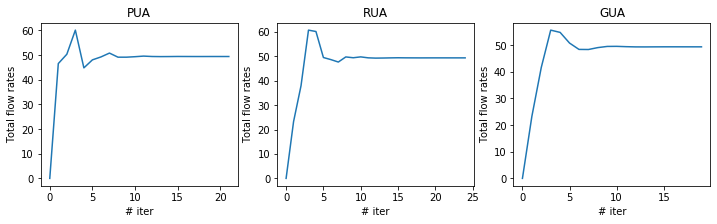

In [0]:

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.plot(pua_rates)
plt.xlabel('# iter')
plt.ylabel('Total flow rates')
plt.title('PUA')

plt.subplot(1, 3, 2)
plt.plot(rua_rates)
plt.xlabel('# iter')
plt.ylabel('Total flow rates')
plt.title('RUA')

plt.subplot(1, 3, 3)
plt.plot(gua_rates)
plt.xlabel('# iter')
plt.ylabel('Total flow rates')
plt.title('GUA')

plt.show()

It can be observed that PUA performs much better than in the linear utility cas ewithout delay. This is possibly caused by the decrease of instantaneous demand, due to the delay factor. In other words, _part of the users will not choose their strategies based on current state, instead, they choose their actions based on past history, and the actions that already being done by other less-delay users_, which makes their strategy more reasonable and less myopic.


Next we do the same investigations on the convergence of PUA, RUA, and GUA, with various parameters.

First we investigate the convergence of PUA for different $k$ values, in a delayed system.

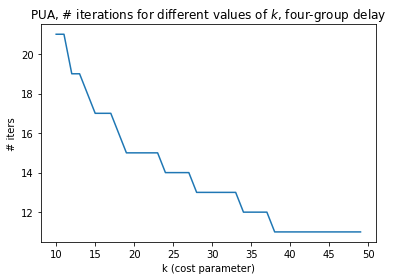

In [0]:
result2 = []
for k in range(10, 50):
    sim = Simulation(M=20, k=k, a=1, delay=lambda MM, ii: int(4 * ii / MM))
    result, n_iter = sim.run(10e-5, sim.pua)
    result2.append([k, n_iter])

result2 = np.array(result2).T

plt.plot(result2[0], result2[1])
plt.xlabel('k (cost parameter)')
plt.ylabel('# iters')
plt.title('PUA, # iterations for different values of $k$, four-group delay')
plt.show()
    

In the delayed system, PUA performed better than in the delay-free system.

Next we investigate the RUA with $M \in [1, 100], 0 < p < 1$.

In [0]:

results = []
Ms = np.linspace(1, 100, 20)
ps = np.linspace(0.1, 0.99, 20)
Ms, ps = np.meshgrid(Ms, ps)
iters = np.zeros(shape=Ms.shape)

for i in range(len(Ms)):
    for j in range(len(ps)):
        sim = Simulation(M=int(Ms[i, j]), k=60, a=1, delay=lambda MM,ii:int)
        result, n_iter = sim.run(10e-5, sim.rua, ps[i, j])
        iters[i, j] = n_iter
        

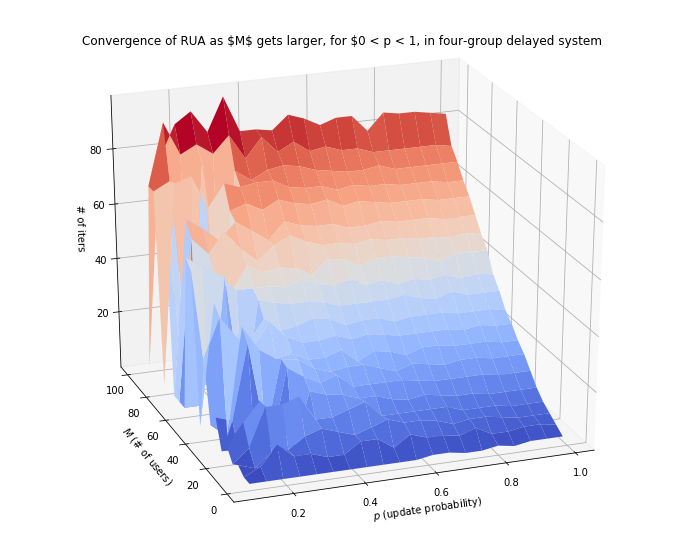

In [0]:
# plot the change of # iters with M and p
fig = plt.figure(figsize=(12, 10))
ax = fig.gca(projection='3d')
ax.plot_surface(X=ps, Y=Ms, Z=iters, cmap=cm.coolwarm, linewidth=1)
ax.view_init(25, 250)
ax.set_xlabel('$p$ (update probability)')
ax.set_ylabel('$M$ (# of users)')
ax.set_zlabel('# of iters')
ax.set_title('Convergence of RUA as $M$ gets larger, for $0 < p < 1, in four-group delayed system')
plt.show()


We can see that there is no optimal update probability in contrast to the delay-free case. The underlying cause is the effect of delay factor on instantaneous demand.

In [0]:

results = []
Ms = np.linspace(1, 100, 20)
ss = np.linspace(0.1, 0.99, 20)
Ms, ss = np.meshgrid(Ms, ss)
iters = np.zeros(shape=Ms.shape)

for i in range(len(Ms)):
    for j in range(len(ss)):
        sim = Simulation(M=int(Ms[i, j]), k=60, a=1, delay=lambda MM,ii:int(4*ii/MM))
        result, n_iter = sim.run(10e-5, sim.gua, ss[i, j])
        iters[i, j] = n_iter
        

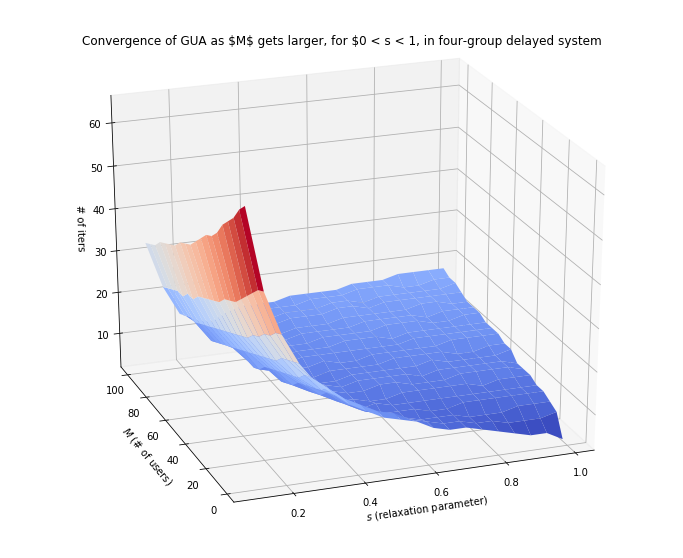

In [0]:

# plot the change of # iters with M and s
fig = plt.figure(figsize=(12, 10))
ax = fig.gca(projection='3d')
ax.plot_surface(X=ps, Y=Ms, Z=iters, cmap=cm.coolwarm, linewidth=1)
ax.view_init(25, 250)
ax.set_xlabel('$s$ (relaxation parameter)')
ax.set_ylabel('$M$ (# of users)')
ax.set_zlabel('# of iters')
ax.set_title('Convergence of GUA as $M$ gets larger, for $0 < s < 1, in four-group delayed system')
plt.show()

# Visualize the cost function


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:973: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


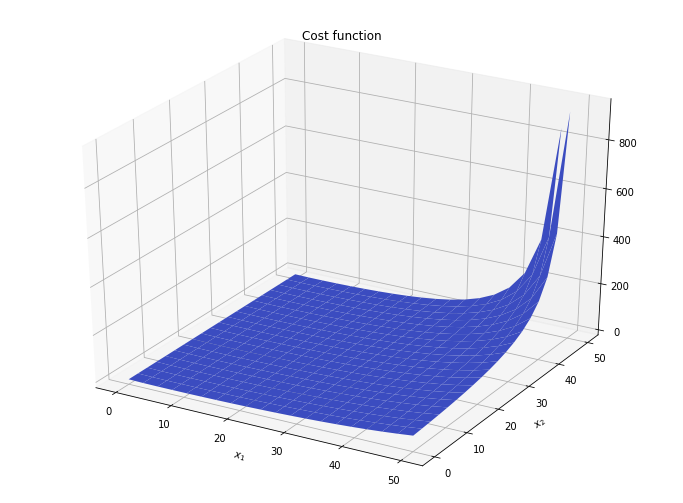

In [0]:
n = 20
m = 100

x1 = np.linspace(0, 50, n)
x2 = np.linspace(0, 50, n)
x1, x2 = np.meshgrid(x1, x2)

J = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        J[i, j] = x1[i, j] * x1[i, j] / (m - x1[i, j] - x2[i, j]) - np.log(1 + x1[i, j]) - 1

fig = plt.figure(figsize=(12, 9))
ax = fig.gca(projection='3d')
ax.plot_surface(x1, x2, J, cmap=cm.coolwarm)
plt.title('Cost function')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()




### Note

The cost function $J(x_i, x_{-i})$ is not an 1-D function w.r.t. $x_i$ only; it depends on $x_{-i}$ too. This is the nature of the cost function. The solution has to depend on $x_{-i}$.



# Discrete Q-Learning



In [0]:
def softmax(x):
    """softmax function.
    :param x: A 2-D vector, shape: (N, K), N = # of data points
    """
    e = np.exp(x - np.max(x, axis=1)[:,None])
    s = np.sum(e, axis=1)[:,None]   # row-wise sum
    return e / s                    # Divide each elem with corresponding row

class DiscreteQLearning:

    def __init__(self, M,  k, a, m=10, d=1, gamma=0.2):
        """
        :param M: number of users
        :param k: price parameter
        :param delay: A function used to decide the delay factor. The function will be called with the following signature:
                        `delay(M, i)`
                      where M is the number of users and i is the user currently dealing with.
                      Return the delay corresponding to the i-th user.

                      For example, the 4-group
            
        """
        self.M = M
        self.m = m
        self.k = k
        self.a = a
        self.d = d
        self.gamma = gamma
        
        self.reset()

    def reset(self):
        # State variables
        self.zs = np.zeros((self.M, self.m))

        # mixed strategies
        self.Xs = np.random.rand(self.M, self.m)
        self.Xs = self.Xs / np.sum(self.Xs, axis=1, keepdims=True)

        # actions
        self.xs = np.random.randint(0, self.m, self.M, dtype=np.uint16)


    def log_cost(self, xs):
        price = self.k / (self.m - np.sum(xs)) * xs * xs
        utility = np.log(1 + xs) + self.d
        return price - utility

    def xs_next(self):
        costs = self.log_cost(self.xs)

        # update zs
        for i in range(self.M):
            j = self.xs[i]          # realized action
            ratio = self.gamma / self.Xs[i, j]     # regularization
            self.zs[i, j] = (1 - ratio) * self.zs[i, j] + ratio * (-costs[i])

        # update Xs
        self.Xs = softmax(self.zs)

        # choose xs
        for i in range(self.M):
            self.xs[i] = np.random.choice(np.arange(self.m), p=self.Xs[i])

    def threshold(self, diff, epsilon):
        """Test if current strategies reach the threshold, given by `epsilon`.
        """
        return np.sum(np.abs(diff)) <= self.M * epsilon

    def run(self, epsilon):
        """Run the simulation.
        """
        for i in range(100):
            self.xs_next()
            print(self.xs)


sim = DiscreteQLearning(5, 4, 1)
sim.run(10e-5)


[4 8 6 6 1]
[4 8 6 6 1]
[4 8 6 6 1]
[4 8 6 6 1]
[4 8 6 6 1]
[4 8 6 6 1]
[4 8 6 6 1]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[4 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 1]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 4]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8 6 6 8]
[8 8

## References

[1] T. Alpcan and T. Başar.  "Distributed Algorithms for Nash Equilibria of Flow Control Games". _Advances in Dynamic Games: Applications to Economics, Finances, Optimization, and Stochastic Control, Annals of Dynamic Games_, 7:473-498, 2005.
